# Nearest Neighbors discriminant (3)

See: https://scikit-learn.org/stable/modules/neighbors.html

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

### (1) Define 2D sample generation procedure

In [2]:
# Generate 2D normal distributed sample using method from lecture 4

def mydata(Nmc,pos,sig,corr=0.0):

    data = np.empty(shape=(Nmc,2))
    
    phi = 0.5*np.arcsin(corr)

    g = np.random.normal(size=(2,Nmc))

    data[:,0] = pos[0] + sig[0]*(g[0]*np.cos(phi) + g[1]*np.sin(phi))
    data[:,1] = pos[1] + sig[1]*(g[0]*np.sin(phi) + g[1]*np.cos(phi))
    
    return data

### (2) Generating train and test data

In [3]:
# Sample size

Ntrain = 1000
Ntest = 100

# Two hypothesis

h1 = np.array([-1.,-0.01])
h2 = np.array([1.,0.01])

# Fraction of first hypothesis

fh1 = 0.5

# Measurement uncertainties

sig = np.array([1.2,0.006])
corr = 0.3

# Generate train sample 
# ---------------------

h1train = mydata(Ntrain,h1,sig,corr)
h2train = mydata(Ntrain,h2,sig,corr)

# Uniform distributed numbers

rtrain = np.random.uniform(size=Ntrain)

# Mix of two hypothesis

y_train = rtrain > fh1

y2_train = np.resize(np.repeat(y_train,2),(Ntrain,2))

X_train = y2_train * h1train + (1 - y2_train)*h2train

print("Train data defined, size: ",y_train.size)

# Generate test sample 
# --------------------

h1test = mydata(Ntest,h1,sig,corr)
h2test = mydata(Ntest,h2,sig,corr)

# Uniform distributed numbers

rtest = np.random.uniform(size=Ntest)

# Mix of two hypothesis

y_test = rtest > fh1

y2_test = np.resize(np.repeat(y_test,2),(Ntest,2))

X_test = y2_test * h1test + (1 - y2_test)*h2test

print("Test data defined, size: ",y_test.size)


Train data defined, size:  1000
Test data defined, size:  100


### (3) Nearest Neighbors classifier 

In [4]:
# Calculate covariance matrix and its inverse

acorr = np.array([[1.,corr],[corr,1.]])

cov = np.outer(sig,sig) * acorr

cinv = np.linalg.inv(cov+cov)

# define distance metric function

def mydist(x1,x2):
    
    dx = x1-x2
    
    dist = dx @ cinv @ dx
    
    return np.sqrt(dist)
    
dtest = mydist(h1,h2)
print("Distance between two hypothesis is :",dtest)

Distance between two hypothesis is : 2.4082682159086435


In [5]:
# Number of neighbors

kn = 10

## Too simple: without taking variable scale differences and correlation into account

# neigh = KNeighborsClassifier(n_neighbors=kn)  

## Proper way: define classifier using proper metric

neigh = KNeighborsClassifier(n_neighbors=kn,metric=mydist)

## The same, but using built-in metric

# neigh = KNeighborsClassifier(n_neighbors=kn,metric='mahalanobis', metric_params={'VI': cinv},n_jobs=8)  

neigh.fit(X_train, y_train)

y_train_pred = neigh.predict(X_train)

print("Number of mislabeled training points out of a total %d points : %d"
        % (X_train.shape[0], (y_train != y_train_pred).sum()))

y_test_pred = neigh.predict(X_test)

print("Number of mislabeled test points out of a total %d points : %d"
        % (X_test.shape[0], (y_test != y_test_pred).sum()))


Number of mislabeled training points out of a total 1000 points : 48
Number of mislabeled test points out of a total 100 points : 4


### (4) Plot results

In [6]:
# 2D grid for decision histogram (as background)

X1min = -5.0
X1max = 5.0
X2min = -0.05
X2max = 0.05
Nbin = 100
dX1 = (X1max-X1min)/Nbin
dX2 = (X2max-X2min)/Nbin

X1range = np.linspace(X1min+0.5*dX1,X1max-0.5*dX1,Nbin)
X2range = np.linspace(X2min+0.5*dX2,X2max-0.5*dX2,Nbin)

X1grid, X2grid = np.meshgrid(X1range,X2range)

yval = np.empty(X1grid.shape)

# Loop over 2D grid (time consuming!)
    
for i in range(Nbin):
    for j in range(Nbin):

        x1 = X1grid[i,j]  
        x2 = X2grid[i,j]  
    
        yval[i,j] = neigh.predict(np.array([[x1,x2]]))

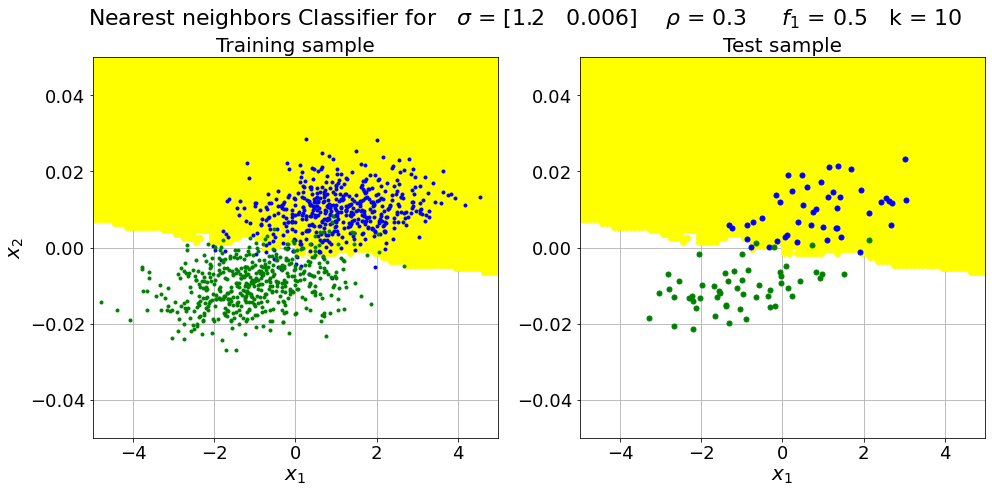

In [8]:
# Create result graph

plt.subplots(1,2,figsize=(16, 7))

plt.suptitle("Nearest neighbors Classifier for   $\sigma$ = "+str(sig)+'    $\\rho$ = '+str(corr)+"     $f_{1}$ = "+str(fh1)+"   k = "+str(kn),fontsize=22)

# Train sample

plt.subplot(121)

# Decision pattern as background

plt.plot(X1grid[yval==0],X2grid[yval==0],'o',color='yellow')
plt.xlim([X1min,X1max])
plt.ylim([X2min,X2max])

# Training points in two categories

plt.plot(X_train[:,0][y_train==0],X_train[:,1][y_train==0],'o',color='blue',ms=3)
plt.plot(X_train[:,0][y_train==1],X_train[:,1][y_train==1],'o',color='green',ms=3)

plt.title("Training sample",size=20)
plt.xlabel('$x_1$',size=20)
plt.ylabel('$x_2$',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

# Test sample

plt.subplot(122)

# Decision pattern as background

plt.plot(X1grid[yval==0],X2grid[yval==0],'o',color='yellow')
plt.xlim([X1min,X1max])
plt.ylim([X2min,X2max])

# Test points in two categories

plt.plot(X_test[:,0][y_test==0],X_test[:,1][y_test==0],'o',color='blue',ms=5)
plt.plot(X_test[:,0][y_test==1],X_test[:,1][y_test==1],'o',color='green',ms=5)

plt.title("Test sample",size=20)
plt.xlabel('$x_1$',size=20)
# plt.ylabel('$x_2$',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')


fname = '12_kNN3_'+str(sig[0])+'_'+str(sig[1])+'_'+str(corr)+'_'+str(fh1)+'_'+str(kn)+'.png'

plt.savefig(fname)

plt.show()